In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split # önemli kütüphanelerin import edilmesi
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torchvision import models
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU kontrolü

transform = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Resimin ImageNet Standartlarında normalize edilmesi

In [2]:
PATH = '../input/EEGIMAGEPSD'

data = datasets.ImageFolder(PATH, transform = transform) # dataset oluşturulması
print(data)
np.random.seed(42)

train_size = int(0.70 * len(data)) # istenilen oranda datasetin train/test şeklinde bölünmesi
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset ImageFolder
    Number of datapoints: 14895
    Root location: ../input/EEGIMAGEPSD
Dataset has 14895 data points.
Train Dataset has 10426 data points
Test Dataset has 4469 data points.


In [3]:
###HYPERPARAMETERS###
batch_size = 8
num_epochs = 10
learning_rate = 0.01
###HYPERPARAMETERS###

In [4]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(44944, 2560)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(2560, 100)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(100, 5)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

model = Model()
model.to(device)

#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader): ###TRAİNİNG_LOOP
        epoch_start_time = time.time()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time

arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:  #PREDİCTİON LOOP
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/10], Step [1303/1304], Loss: 0.2881: Batch Loss : 0.796589897718232
Epoch [2/10], Step [1303/1304], Loss: 0.2387: Batch Loss : 0.3327264262910815
Epoch [3/10], Step [1303/1304], Loss: 0.0104: Batch Loss : 0.19370188302748587
Epoch [4/10], Step [1303/1304], Loss: 0.5121: Batch Loss : 0.13259967704141315
Epoch [5/10], Step [1303/1304], Loss: 0.0458: Batch Loss : 0.10065644970328096
Epoch [6/10], Step [1303/1304], Loss: 0.0105: Batch Loss : 0.06717847092098579
Epoch [7/10], Step [1303/1304], Loss: 0.0191: Batch Loss : 0.05309124374426244
Epoch [8/10], Step [1303/1304], Loss: 0.0004: Batch Loss : 0.040312755295430706
Epoch [9/10], Step [1303/1304], Loss: 0.0057: Batch Loss : 0.033697343842395894
Epoch [10/10], Step [1303/1304], Loss: 0.0009: Batch Loss : 0.027614668972292773
Test Accuracy of the model on the 10000 test images: 96.21839337659432 %


In [7]:
x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training / 60} dk")

Total Training Time : 19.10399568080902 dk


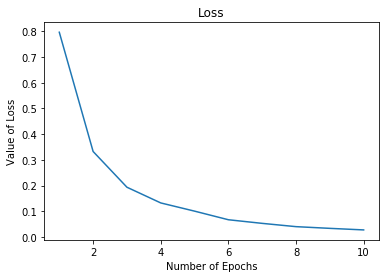

In [8]:
import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

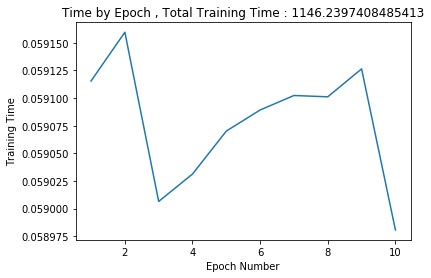

In [9]:
plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

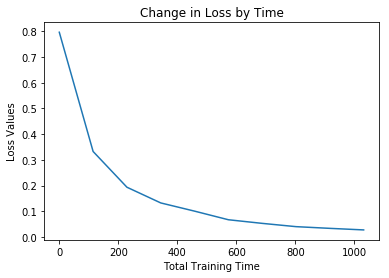

In [10]:
plt.title("Change in Loss by Time")
plt.ylabel("Loss Values")
plt.xlabel("Total Training Time")
plt.plot(x_interval_axis, loss_values)

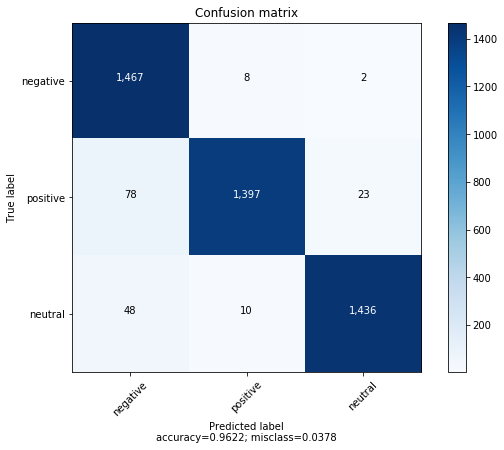

The Accuracy : 96.2183933765943
The Precision : 96.36905131087157
The Recall : 96.23281112788774
The F1 Score : 96.22536610929635


In [11]:
from sklearn import metrics
from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= ["negative", "positive", "neutral"], title='Confusion matrix' , normalize= False)

print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")